In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [24]:
from transformers import AutoModelForSequenceClassification
import torch

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
num_labels = 6
model_ckpt = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [5]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Getting dataset to train model

In [6]:
pip install datasets

In [7]:
import pandas as pd
from transformers import AutoTokenizer

In [8]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [52]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

#Fine tunning model

In [11]:
import transformers

In [12]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  report_to="none",
                                  log_level="error")

In [13]:

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/tmp/ipython-input-4137031082.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.726200,0.249567,0.922500,0.923489
2,0.203000,0.173722,0.933000,0.933338


In [16]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [59]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [57]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [42]:
import matplotlib.pyplot as plt

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [36]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [53]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [60]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [55]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k: v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [44]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


In [61]:
y_valid = np.array(emotions_hidden["validation"]["label"])

In [63]:
labels = emotions["train"].features["label"].names

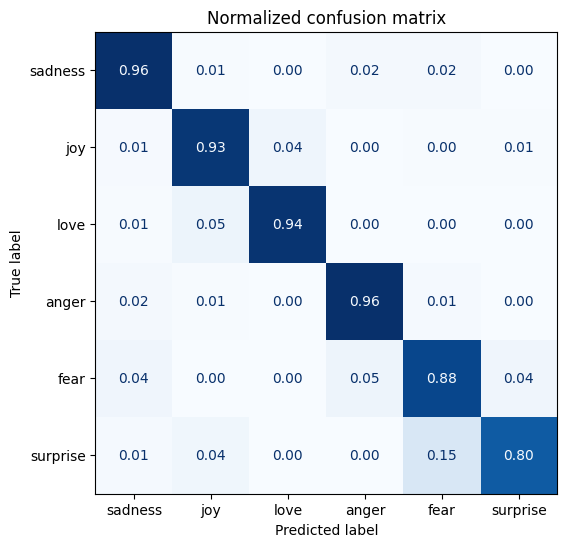

In [64]:
preds_output = trainer.predict(emotions_encoded["validation"])

preds_output.metrics

y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels)